In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep = '|', names = u_cols, encoding = 'latin-1')
users.head()

user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
1        2   53   F       other    94043
2        3   23   M      writer    32067
3        4   24   M  technician    43537
4        5   33   F       other    15213

In [4]:
# person has rated the movie means he watched the movie will be the principle used for recommendation

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep = '\t', names = r_cols, encoding = 'latin-1')
ratings.head()

user_id  movie_id  rating  unix_timestamp
0      196       242       3       881250949
1      186       302       3       891717742
2       22       377       1       878887116
3      244        51       2       880606923
4      166       346       1       886397596

In [5]:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep = '|', names = i_cols, encoding='latin-1')
items.head()

movie id        movie title release date  video release date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's   ...     Fantasy  Film-Noir  Horror  \
0          0          1           1   ...           0          0       0   
1          1          0           0   ...           0          0       0   
2          0          0           0   ...           0          0       0   
3          0          0           0   ...           0          0       0   
4          0          0           0   ...           0          0       0   

   Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0        0       0         0    0        0  
1        0        0        0       0         1    0        0  
2        0        0        0       0         1    0        0  
3        0        0        0       0         0    0        0  
4        0        0        0       0         1    0        0  

[5 rows x 24 columns]

In [6]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
train_df = pd.read_csv('ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
test_df = pd.read_csv('ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')
train_df.shape, test_df.shape

((90570, 4), (9430, 4))

In [7]:
# get mean ratings for every movie and it's count

ratings_info = pd.DataFrame(train_df.groupby('movie_id')['rating'].mean())
ratings_info['number_of_ratings'] = train_df.groupby('movie_id')['rating'].count()
ratings_info.head()

rating  number_of_ratings
movie_id                             
1         3.859694                392
2         3.198347                121
3         3.058824                 85
4         3.545455                198
5         3.291139                 79

C:\Users\admn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


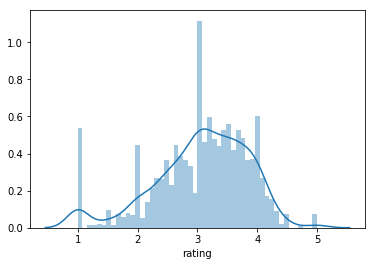

In [8]:
# most of the movies are rated between 2.5 to 4

sns.distplot(ratings_info['rating'], bins = 50)

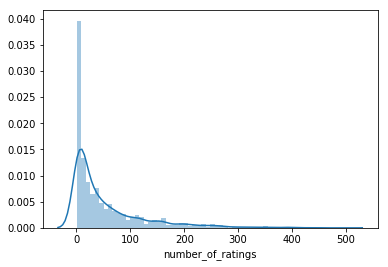

In [9]:
# most movies have few ratings

sns.distplot(ratings_info['number_of_ratings'], bins = 60)

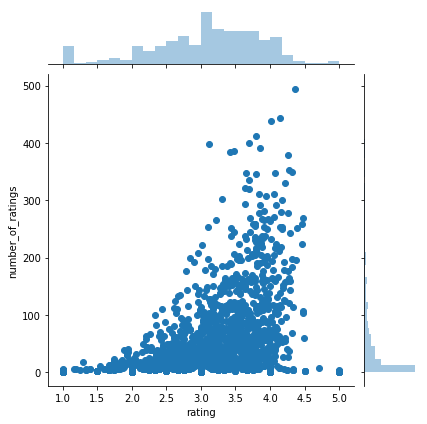

In [10]:
# as more people watch the movie, its average rating increases

sns.jointplot(x = 'rating', y = 'number_of_ratings', data = ratings_info)

In [12]:
# create a user-item matrix to calculate the similarity between users and items

data_matrix = np.array(ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0))

In [13]:
# calculating cosine similarity between user-user and item-item

from sklearn.metrics.pairwise import pairwise_distances 

user_similarity = pairwise_distances(data_matrix, metric = 'cosine')
item_similarity = pairwise_distances(data_matrix.T, metric = 'cosine')

In [14]:
# defining prediction function

def predict(ratings, similarity, type):
    if type == 'user':
        pred = ((similarity.dot(ratings).T) / np.array([np.abs(similarity).sum(axis=1)])).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [15]:
# recommending based on user similarity and item similarity

user_prediction = predict(data_matrix, user_similarity, 'user')
item_prediction = predict(data_matrix, item_similarity, 'item')

In [16]:
user_based_recommendation = np.argsort(-user_prediction, axis = 1)
item_based_recommendation = np.argsort(-item_prediction, axis = 1)

In [35]:
# matrix factorization for recommender system
# http://www.albertauyeung.com/post/python-matrix-factorization/

class MF():

    # Constructor
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        
        # Generating random P and Q to start with for gradient descent to converge
        self.P = np.random.normal(scale=1/self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1/self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        # Every user may have his or her own bias tending to rate items higher or lower than the others. If a user is a serious movie watcher, he or she may tend to give lower ratings, when compared to other users
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Getting non zero elements to act as training samples along with their index
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Training model
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Root mean squared error for non zero elements
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Formula for ratings for user i and movie j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [36]:
mf = MF(data_matrix, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())

Iteration: 20 ; error = 296.1283
Iteration: 40 ; error = 291.0835
Iteration: 60 ; error = 287.8063
Iteration: 80 ; error = 282.7876
Iteration: 100 ; error = 273.6916

P x Q:
[[4.12033685 3.31658767 3.13423397 ... 3.28720028 3.43656006 3.46622294]
 [3.90072454 3.37600207 3.16016284 ... 3.3596629  3.49621992 3.45727576]
 [3.27642248 2.91709072 2.58887541 ... 2.81375842 2.92630524 2.91604629]
 ...
 [4.23691892 3.58069581 3.38723018 ... 3.64016806 3.77967968 3.7008625 ]
 [4.42394276 3.73845112 3.5774097  ... 3.79967708 3.91808758 3.84250025]
 [3.90088047 3.34118644 3.16458464 ... 3.24843438 3.39482234 3.37924926]]

